In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sympy
from sympy import init_printing
init_printing()
from celmech import Poincare,PoincareHamiltonian
from celmech.nbody_simulation_utilities import align_simulation

from celmech.symplectic_evolution_operators import LinearSecularEvolutionOperator
from celmech.symplectic_evolution_operators import SecularDFTermsEvolutionOperator
from celmech import LaplaceLagrangeSystem
import rebound as rb
COMPARE = False # Set true to compare numerical results from operator to sympy

In [2]:
def get_sim():
    sim = rb.Simulation()
    sim.add(m=1)
    for i in range(1,4):
        sim.add(m=i * 1e-5 , a = 2**i, 
                e = np.random.rayleigh(0.06),
                inc = np.random.rayleigh(0.06),
                l = 'uniform',
                pomega = 'uniform',
                Omega = 'uniform'
               )
    sim.move_to_com()
    align_simulation(sim)
    return sim

In [3]:
class SecularSystemSimulation():
    def __init__(self,initial_state,state_vector,dt,Nmin,Nmax,Lambda0=None):
        self.linearSecOp = LinearSecularEvolutionOperator(
            initial_state,
            0.5 * self.dt
        )
        self.nonlinearSecOp = \
        SecularDFTermsEvolutionOperator.fromOrderRange(
            initial_state,dt,
            Nmin,Nmax,Lambda0 = Lambda0
        )
        self.t = 0
        self.state_vector = state_vector
    def step(self):
        pass

# Initialize simulation objects and evolution operators

In [4]:
np.random.seed(123)

sim = get_sim()
pvars = Poincare.from_Simulation(sim)
llsys = LaplaceLagrangeSystem.from_Poincare(pvars)
Tsec = min(2 * np.pi / np.abs(llsys.eccentricity_eigenvalues()))
dt = Tsec / 50.

Nmin = 4
Nmax = 4

# Solves e^2/i^2 terms exactly
secLinearOp = LinearSecularEvolutionOperator(pvars, 0.5 * dt)
# Solves terms of order Nmin to Nmax in e/i by implicit midpoint
secDFOp = SecularDFTermsEvolutionOperator.fromOrderRange(pvars,dt,Nmin,Nmax)

In [5]:
pham = PoincareHamiltonian(pvars)
state_vec = np.array(pham.state_to_list(pvars))

# Compare numerical value of derivatives from operator and Poincare Hamiltonian

In [6]:
if COMPARE:
    from sympy import symbols,diff,Matrix
    from celmech.miscellaneous import getOmegaMatrix

    from celmech.disturbing_function import SecularTermsList
    secular_terms = SecularTermsList(Nmin,Nmax)
    # Remove Keplerian term
    pham.H -= PoincareHamiltonian(pvars).H
    for i in range(1,pham.N):
        for j in range(i+1,pham.N):
            for term in secular_terms:
                pham.add_monomial_term(*term,i,j,update=False)
    pham.set_secular_mode()
    pham._update()


    symstring = ",".join([
            sym + str(i) 
            for sym in ['eta','rho','kappa','sigma'] 
            for i in range(1,pvars.N)
        ])
    symlist = symbols(symstring)

    qp_vec = secDFOp.state_vec_to_qp_vec(state_vec)
    H = secDFOp.calculate_Hamiltonian(state_vec)
    d,J = secDFOp.deriv_and_jacobian_from_qp_vec(qp_vec)
    subsrule = dict(zip(pham.varsymbols,state_vec))
    symH =  np.float64(pham.NH.subs(subsrule))
    print("Hamiltonians match?" , np.isclose(H ,symH, atol=0) )
    
    symDeriv = getOmegaMatrix(6) @ np.array([diff(pham.NH,s).subs(subsrule) for s in symlist],dtype=np.float64)
    print("Derivatives match?", np.alltrue(np.isclose(d ,symDeriv, atol=0))) 
    symJac = getOmegaMatrix(6) @ Matrix(12,12,
                                        lambda i,j: diff(pham.NH,symlist[i],symlist[j]).subs(subsrule)
                                       )
    symJac = np.array(symJac.tolist(),dtype=np.float64)
    print("Jacobians match?", np.alltrue(np.isclose(J  , symJac, atol=0)))

# Integration

## numerical secular model

In [7]:
def run_secular_sim(state_vec,dt,N):
    secDFOp.dt = dt
    secLinearOp.dt = 0.5 * dt
    etaN,kappaN,rhoN,sigmaN = np.zeros((4,pvars.N - 1,N))
    EnergyN = np.zeros(N)
    times = np.zeros(N)
    for i in range(N):
        times[i] = i * dt
        EnergyN[i] =  secLinearOp.caluclate_Hamiltonian(state_vec)
        EnergyN[i] += secDFOp.calculate_Hamiltonian(state_vec)
        for j,p in enumerate(pham.particles[1:]):
            etaN[j,i] = state_vec[6 * j + 1]
            kappaN[j,i] = state_vec[6 * j ]
            rhoN[j,i] = state_vec[6 * j + 5]
            sigmaN[j,i] = state_vec[6 * j + 4]
        state_vec = secLinearOp.apply_to_state_vector(state_vec)
        state_vec = secDFOp.apply_to_state_vector(state_vec)
        state_vec = secLinearOp.apply_to_state_vector(state_vec)
        
    return times,EnergyN,etaN,kappaN,rhoN,sigmaN

In [8]:
%time times,EnergyN,etaN,kappaN,rhoN,sigmaN = run_secular_sim(state_vec,dt, 512 )

/Users/shadden/Projects/celmech/celmech/symplectic_evolution_operators.py:1014: UserWarning: Implicit step failed to converge.
  warnings.warn("Implicit step failed to converge.")


CPU times: user 1.57 s, sys: 26.6 ms, total: 1.6 s
Wall time: 1.52 s


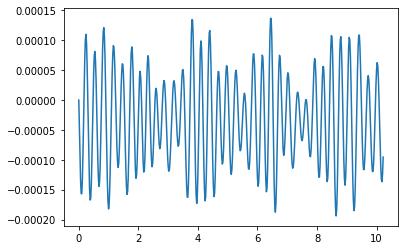

In [9]:
plt.plot(times/Tsec,(EnergyN - EnergyN[0]) / EnergyN[0])

In [10]:
# Compute eccentricities
GammaByL = np.transpose(0.5 * (kappaN**2 + etaN**2).T / np.array([p.Lambda for p in pvars.particles[1:]]))
eccN = np.sqrt(1 - (1-GammaByL)*(1-GammaByL))
Q = 0.5 * (rhoN**2 + sigmaN**2)

In [11]:
G = np.transpose(np.array([p.Lambda for p in pvars.particles[1:]]) * ( 1- GammaByL).T)
incN = np.arccos(1- Q / G)

## $N$-body

In [12]:
from celmech.nbody_simulation_utilities import set_timestep,get_simarchive_integration_results
sim.integrator = 'whfast'
set_timestep(sim,1/30.)
sim.ri_whfast.safe_mode=0
sim.automateSimulationArchive('sa_secular.bin',interval=times[1],deletefile=True)

In [13]:
%time sim.integrate(times[-1])

CPU times: user 45.6 s, sys: 534 ms, total: 46.1 s
Wall time: 49.6 s


In [14]:
nbody_results = get_simarchive_integration_results(rb.SimulationArchive('./sa_secular.bin'))

## Laplace-Lagrange solution

In [15]:
llsoln = llsys.secular_solution(times)

## Comparison

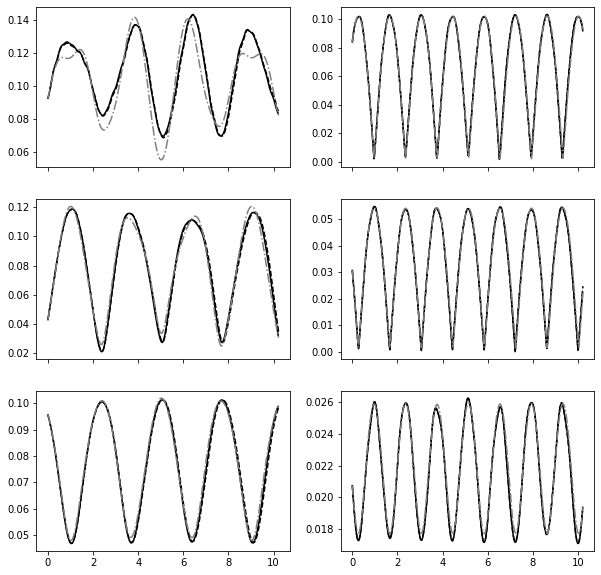

In [16]:
fig,ax = plt.subplots(3,2,figsize=(10,10),sharex=True)
for i in range(3):
    ax[i,0].plot(nbody_results['time']/Tsec,nbody_results['e'][i],color='k')
    ax[i,0].plot(times/Tsec,eccN[i],'--',color='k')
    ax[i,0].plot(times/Tsec,llsoln['e'][i],ls='-.',color='gray')
    
    ax[i,1].plot(nbody_results['time']/Tsec,nbody_results['inc'][i],color='k')
    ax[i,1].plot(times/Tsec,incN[i],'--',color='k')
    ax[i,1].plot(times/Tsec,llsoln['inc'][i],ls='-.',color='gray')